In [80]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt

M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])


In [81]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

In [82]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX04262024_angle_test"
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

In [83]:
loc_pred = [np.array([0,0,0])]
angle_pred = [np.array([0,0,0])]
B_stdev = [np.array(pos)]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
    x_res = minimize(x0, B, pos, M0, shape)
    loc_pred = np.append(loc_pred, [x_res[0:3]], axis=0)
    angle_pred = np.append(angle_pred, [x_res[3:6]], axis=0)
    B_stdev = np.append(B_stdev, [mags_stdev], axis=0)
loc_pred = np.delete(loc_pred, 0, axis=0)
angle_pred = np.delete(angle_pred, 0, axis=0)
B_stdev = np.delete(B_stdev, 0 ,axis=0)

In [84]:
np.append(loc_pred, angle_pred, axis=1)
#np.sum(angle_pred**2)

array([[-4.05269761e+00, -1.53375188e+00,  1.33982526e+01,
        -5.78007739e-02, -8.85171464e-02,  9.94396191e-01],
       [-3.99540272e+00, -5.59754782e-01,  1.34493676e+01,
        -4.96007218e-02, -6.23795817e-02,  9.96819219e-01],
       [-3.95065357e+00,  4.22104364e-01,  1.34654007e+01,
        -4.36567588e-02, -3.61265342e-02,  9.98393190e-01],
       [-3.91187120e+00,  1.36914746e+00,  1.34469154e+01,
        -3.88158445e-02, -9.59566754e-03,  9.99200307e-01],
       [-3.86977963e+00,  2.38814440e+00,  1.33927053e+01,
        -3.45879569e-02,  2.07555135e-02,  9.99186110e-01],
       [-3.05375485e+00, -1.59377621e+00,  1.42032134e+01,
        -2.48646094e-02, -7.97120360e-02,  9.96507773e-01],
       [-3.00059649e+00, -5.82866420e-01,  1.42532695e+01,
        -1.71312329e-02, -5.23378873e-02,  9.98482482e-01],
       [-2.94600306e+00,  4.31669037e-01,  1.42683751e+01,
        -1.08890718e-02, -2.62110912e-02,  9.99597122e-01],
       [-2.90301421e+00,  1.42125837e+00,  1.424

In [85]:
actang = [np.array([0, 0, 0])]
for y in range(5):
    for z in range(5):
        add = np.array([np.sin(np.deg2rad(2*y-4)), np.sin(np.deg2rad(2*z-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*z-4))])
        actang = np.append(actang, [add], axis=0)
actang = np.delete(actang, 0, axis=0)
locact = actang*15
np.sum(actang**2)

25.000148057327994

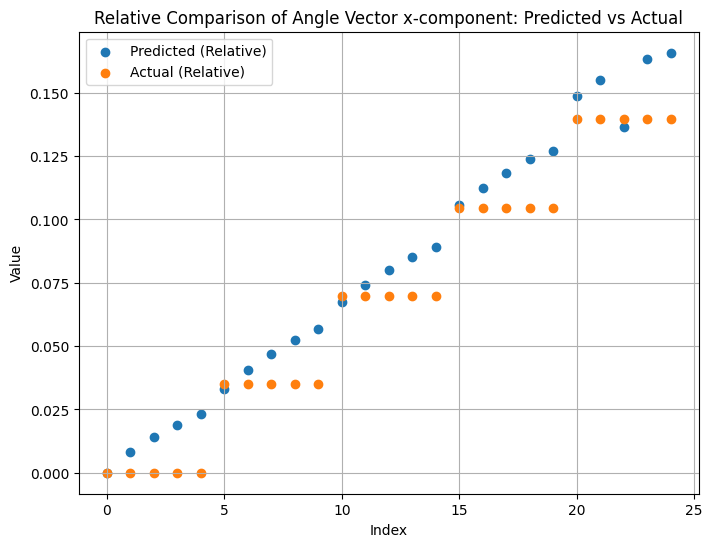

In [86]:
rel_ang_predx = [x-angle_pred[0,0] for x in angle_pred[:,0]]
rel_actangx = [x - actang[0,0] for x in actang[:,0]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_ang_predx))), rel_ang_predx, label='Predicted (Relative)')
plt.scatter(list(range(len(rel_actangx))), rel_actangx, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Relative Comparison of Angle Vector x-component: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

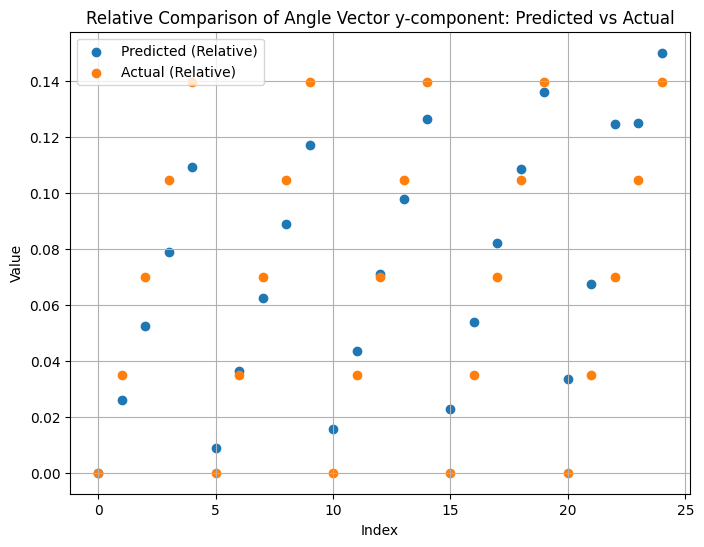

In [87]:
rel_ang_predy = [x-angle_pred[0,1] for x in angle_pred[:,1]]
rel_actangy = [x - actang[0,1] for x in actang[:,1]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_ang_predy))), rel_ang_predy, label='Predicted (Relative)')
plt.scatter(list(range(len(rel_actangy))), rel_actangy, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Relative Comparison of Angle Vector y-component: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

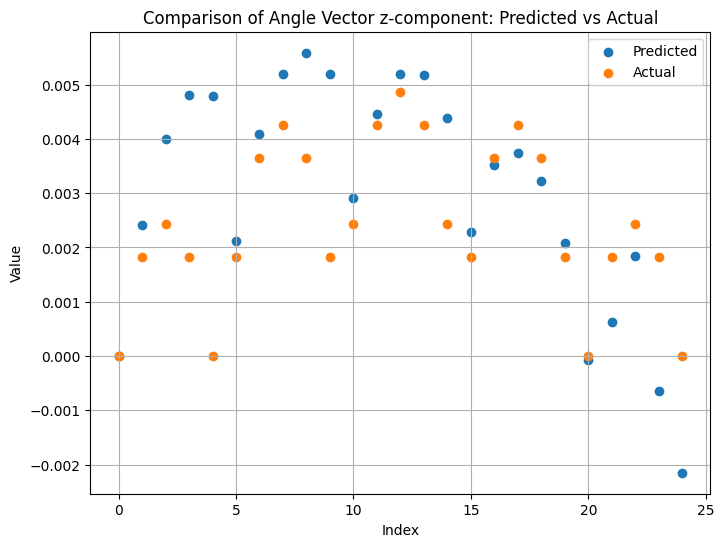

In [88]:
rel_ang_predz = [x-angle_pred[0,2] for x in angle_pred[:,2]]
rel_actangz = [x - actang[0,2] for x in actang[:,2]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_ang_predz))), rel_ang_predz, label='Predicted')
plt.scatter(list(range(len(rel_actangz))), rel_actangz, label='Actual')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Angle Vector z-component: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

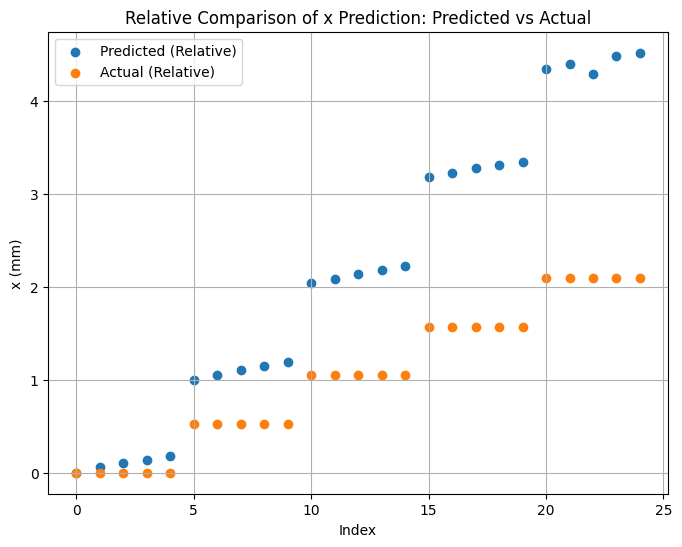

In [89]:
rel_locactx = [x-locact[0,0] for x in locact[:,0]]
rel_loc_predx = [x - loc_pred[0,0] for x in loc_pred[:,0]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predx))), rel_loc_predx, label='Predicted (Relative)')
plt.scatter(list(range(len(rel_locactx))), rel_locactx, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('x (mm)')
plt.title('Relative Comparison of x Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

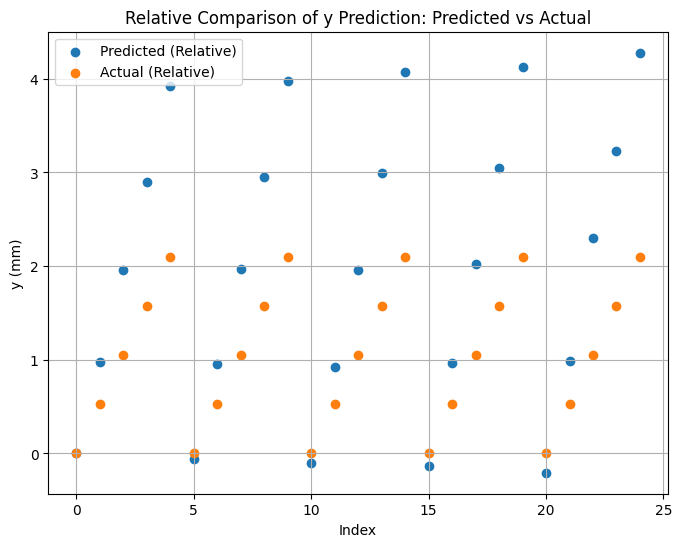

In [90]:
rel_locacty = [x-locact[0,1] for x in locact[:,1]]
rel_loc_predy = [x - loc_pred[0,1] for x in loc_pred[:,1]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predy))), rel_loc_predy, label='Predicted (Relative)')
plt.scatter(list(range(len(rel_locacty))), rel_locacty, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('y (mm)')
plt.title('Relative Comparison of y Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

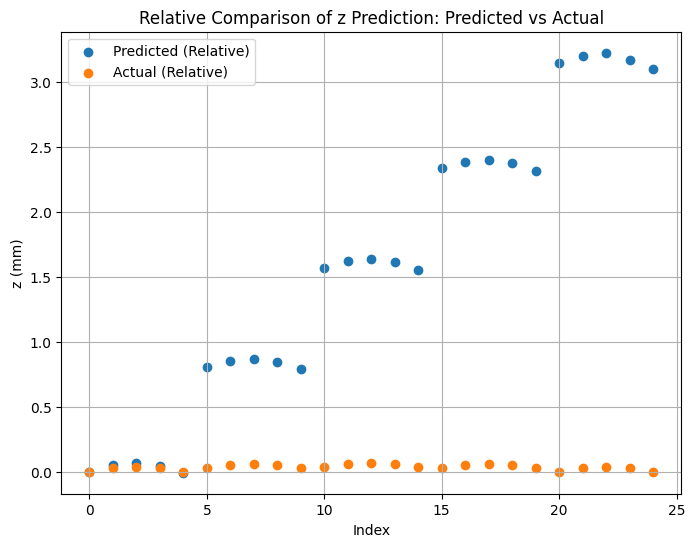

In [91]:
rel_locactz = [x-locact[0,2] for x in locact[:,2]]
rel_loc_predz = [x - loc_pred[0,2] for x in loc_pred[:,2]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predz))), rel_loc_predz, label='Predicted (Relative)')
plt.scatter(list(range(len(rel_locactz))), rel_locactz, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('z (mm)')
plt.title('Relative Comparison of z Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()